In [14]:
import pandas as pd
import numpy as np
import pickle

import itertools
import xgboost as xgb
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

import matplotlib
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns


x_train_text = pd.read_csv('../input/combined-data/text_train.csv')
x_test_text = pd.read_csv('../input/combined-data/text_test.csv')

y_train_text = x_train_text['label']
y_test_text = x_test_text['label']

x_train_audio = pd.read_csv('../input/combined-data/audio_train.csv')
x_test_audio = pd.read_csv('../input/combined-data/audio_test.csv')


y_train_audio = x_train_audio['label']
y_test_audio = x_test_audio['label']

y_train = y_train_audio  # since y_train_audio == y_train_text
y_test = y_test_audio  # since y_train_audio == y_train_text

print(x_train_text.shape, y_train_text.shape, x_train_audio.shape, y_train_audio.shape)

(7837, 3) (7837,) (7837, 15) (7837,)


In [15]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])

id_to_emotion = {0: 'ang', 1: 'hap', 2: 'sad', 3: 'fea', 4: 'sur', 5: 'neu'}

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [16]:
cl_weight = dict(pd.Series(x_train_audio['label']).value_counts(normalize=True))

## Get Text Features

In [17]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features_text = tfidf.fit_transform(x_train_text.append(x_test_text).transcription).toarray()

x_train_text = features_text[:x_train_text.shape[0]]
x_test_text = features_text[-x_test_text.shape[0]:]

print(features_text.shape, x_train_text.shape, x_test_text.shape)

(9797, 2464) (7837, 2464) (1960, 2464)


## Combine Text + Audio Features

In [18]:
combined_x_train = np.concatenate((np.array(x_train_audio[x_train_audio.columns[2:]]), x_train_text), axis=1)
combined_x_test = np.concatenate((np.array(x_test_audio[x_test_audio.columns[2:]]), x_test_text), axis=1)

print(combined_x_train.shape, combined_x_test.shape)

combined_features_dict = {}

combined_features_dict['x_train'] = combined_x_train
combined_features_dict['x_test'] = combined_x_test
combined_features_dict['y_train'] = np.array(y_train)
combined_features_dict['y_test'] = np.array(y_test)

with open('combined_features.pkl', 'wb') as f:
    pickle.dump(combined_features_dict, f)

(7837, 2477) (1960, 2477)


Test Set Accuracy =  0.658
Test Set F-score =  0.662
Test Set Precision =  0.714
Test Set Recall =  0.653
Confusion matrix, without normalization
[[ 89  20 112   0   0   4]
 [ 20 128 141   2   2  22]
 [ 37  33 485   1   1  37]
 [  0   0   0 249   0   0]
 [  0   0   0   0 238   0]
 [  9  25 199   1   4 101]]


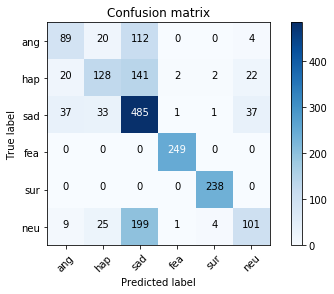

In [19]:
rf_classifier = RandomForestClassifier(n_estimators=600, min_samples_split=25)
rf_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = rf_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('combined_rf_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.654
Test Set F-score =  0.660
Test Set Precision =  0.693
Test Set Recall =  0.653
Confusion matrix, without normalization
[[103  17  94   0   3   8]
 [ 29 128 117   4   6  31]
 [ 50  26 464   2   5  47]
 [  0   0   0 249   0   0]
 [  0   0  13   4 221   0]
 [ 10  29 174   4   5 117]]


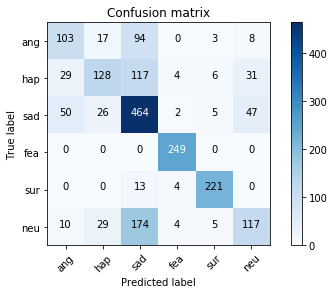

In [20]:
xgb_classifier = xgb.XGBClassifier(max_depth=7, learning_rate=0.008, objective='multi:softprob', 
                                   n_estimators=600, sub_sample=0.8, num_class=len(emotion_dict),
                                   booster='gbtree', n_jobs=4)
xgb_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = xgb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('combined_xgb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.657
Test Set F-score =  0.666
Test Set Precision =  0.664
Test Set Recall =  0.674
Confusion matrix, without normalization
[[116  13  67   6   6  17]
 [ 11 203  41  11  13  36]
 [ 45  36 381  19  20  93]
 [  0   0   0 242   0   7]
 [  0   8  16  12 202   0]
 [ 11  39 109  13  23 144]]


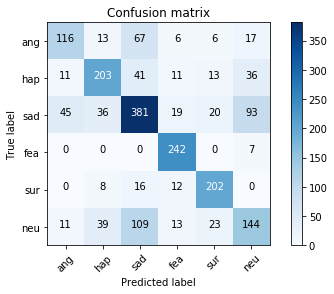

In [21]:
svc_classifier = LinearSVC()

svc_classifier.fit(combined_x_train, y_train)

# Predict
pred = svc_classifier.predict(combined_x_test)

# Results
one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
print('Test Set F-score =  {0:.3f}'.format(f1_score(y_test, pred, average='macro')))
print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)
(y_test, pred_probs)

with open('combined_svc_classifier_model.pkl', 'wb') as f:
    pickle.dump(svc_classifier, f)

Test Set Accuracy =  0.585
Test Set F-score =  0.580
Test Set Precision =  0.697
Test Set Recall =  0.544
Confusion matrix, without normalization
[[ 72  11 127   2   3  10]
 [  2 161 111  12  10  19]
 [ 23  19 505   3   3  41]
 [  0   0  68 181   0   0]
 [  0   6  88   0 144   0]
 [  4  21 213  10   7  84]]


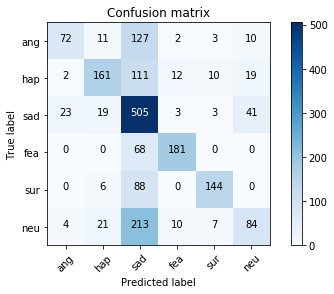

In [22]:
mnb_classifier = MultinomialNB()

mnb_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mnb_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('combined_mnb_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.682
Test Set F-score =  0.701
Test Set Precision =  0.697
Test Set Recall =  0.706
Confusion matrix, without normalization
[[120  10  69   1   5  20]
 [ 18 194  39   4   8  52]
 [ 50  43 388   2   9 102]
 [  0   0   0 249   0   0]
 [  0   0   0   0 238   0]
 [ 12  54 114   3   9 147]]


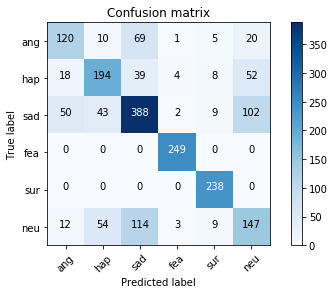

In [23]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(500, ), activation='relu', solver='adam', alpha=0.0001,
                               batch_size='auto', learning_rate='adaptive', learning_rate_init=0.01,
                               power_t=0.5, max_iter=1000, shuffle=True, random_state=None, tol=0.0001,
                               verbose=False, warm_start=True, momentum=0.8, nesterovs_momentum=True,
                               early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999,
                               epsilon=1e-08)

mlp_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = mlp_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('combined_mlp_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

Test Set Accuracy =  0.644
Test Set F-score =  0.651
Test Set Precision =  0.672
Test Set Recall =  0.641
Confusion matrix, without normalization
[[110  16  77   2   5  15]
 [ 12 184  64  10  12  33]
 [ 37  31 432   8  14  72]
 [  7   0  24 218   0   0]
 [  0  10  35   8 184   1]
 [  6  42 129   8  19 135]]


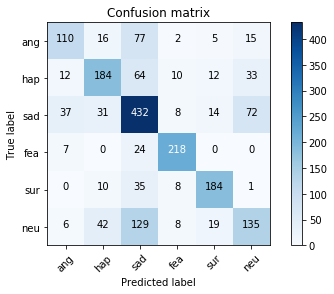

In [24]:
lr_classifier = LogisticRegression(solver='lbfgs', multi_class='multinomial', max_iter=1000)

lr_classifier.fit(combined_x_train, y_train)

# Predict
pred_probs = lr_classifier.predict_proba(combined_x_test)

# Results
display_results(y_test, pred_probs)

with open('combined_lr_classifier.pkl', 'wb') as f:
    pickle.dump(pred_probs, f)

[0.00091521 0.00139297 0.0030234  ... 0.         0.         0.        ]


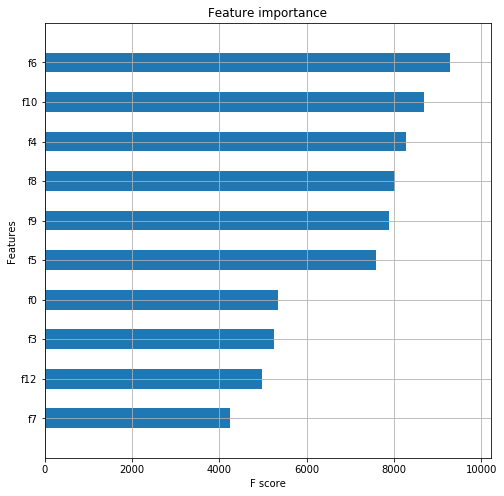

In [25]:
ax = xgb.plot_importance(xgb_classifier, max_num_features=10, height=0.5, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)
contribution_scores = xgb_classifier.feature_importances_
print(contribution_scores)

Test Set Accuracy =  0.710
Test Set F-score =  0.722
Test Set Precision =  0.738
Test Set Recall =  0.717
Confusion matrix, without normalization
[[116   9  85   0   2  13]
 [ 15 192  61   5   5  37]
 [ 36  28 460   1   3  66]
 [  0   0   0 249   0   0]
 [  0   0   0   0 238   0]
 [  8  43 142   2   7 137]]


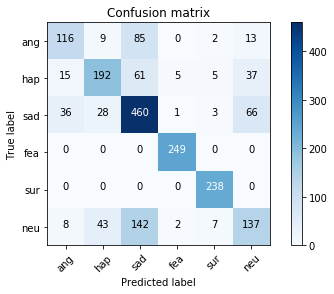

In [26]:
# Load predicted probabilities
with open('combined_rf_classifier.pkl', 'rb') as f:
    rf_pred_probs = pickle.load(f)

with open('combined_xgb_classifier.pkl', 'rb') as f:
    xgb_pred_probs = pickle.load(f)
    
with open('combined_svc_classifier_model.pkl', 'rb') as f:
    svc_preds = pickle.load(f)
    
with open('combined_mnb_classifier.pkl', 'rb') as f:
    mnb_pred_probs = pickle.load(f)
    
with open('combined_mlp_classifier.pkl', 'rb') as f:
    mlp_pred_probs = pickle.load(f)
    
with open('combined_lr_classifier.pkl', 'rb') as f:
    lr_pred_probs = pickle.load(f)


# Average of the predicted probabilites
ensemble_pred_probs = (xgb_pred_probs +
                       mlp_pred_probs +
                       rf_pred_probs +
                       mnb_pred_probs +
                       lr_pred_probs)/4.0
# Show metrics
display_results(y_test, ensemble_pred_probs)